In [79]:
from typing import Optional
import json
import os
import random
import gym
from gym import spaces
import numpy as np
import random
import json
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

class StockDataHandler:
    """
    A simplified handler for navigating through stock data organized as stockticker -> year -> month -> features.
    This version does only what's necessary for interacting with the stock data and has no unnecessary methods or prints.
    """
    def __init__(self, json_file_path: str):
        """
        Initialize the StockDataHandler by loading data from the provided JSON file.
        """
        if not os.path.exists(json_file_path):
            raise FileNotFoundError(f"The file '{json_file_path}' does not exist.")

        with open(json_file_path, 'r') as file:
            try:
                self.data = json.load(file)
            except json.JSONDecodeError as e:
                raise ValueError(f"Error decoding JSON: {e}")

        if not isinstance(self.data, dict):
            raise ValueError("JSON data must be a dictionary at the top level.")

        self.stock_tickers = sorted(self.data.keys())
        self.current_stock = None
        self.current_year = None
        self.current_month = None
        self.sorted_years = []
        self.sorted_months = []

    def get_stock(self, ticker: Optional[str] = None, year: Optional[str] = None, month: Optional[str] = None) -> dict:
        """
        Retrieve features for a specified stock ticker, year, and month.
        If ticker is None, a random ticker is selected.
        """
        if ticker is None:
            ticker = random.choice(self.stock_tickers)
        self.current_stock = ticker.upper()
        self.sorted_years = sorted(self.data[self.current_stock].keys(), key=lambda y: int(y))

        if year is None:
            year = self.sorted_years[0]
        self.current_year = year

        self.sorted_months = sorted(self.data[self.current_stock][self.current_year].keys(), key=lambda m: int(m))
        if month is None:
            month = self.sorted_months[0]
        self.current_month = month

        return self.data[self.current_stock][self.current_year][self.current_month]

    def step(self) -> dict:
        """
        Move to the next month's features based on the current state.
        :return: A dictionary of features for the next month.
        """
        current_month_idx = self.sorted_months.index(self.current_month)
        if current_month_idx + 1 < len(self.sorted_months):
            self.current_month = self.sorted_months[current_month_idx + 1]
        else:
            current_year_idx = self.sorted_years.index(self.current_year)
            if current_year_idx + 1 < len(self.sorted_years):
                self.current_year = self.sorted_years[current_year_idx + 1]
                self.sorted_months = sorted(self.data[self.current_stock][self.current_year].keys(), key=lambda m: int(m))
                self.current_month = self.sorted_months[0]
            else:
                raise StopIteration("No more data available to step through.")
        
        return self.data[self.current_stock][self.current_year][self.current_month]


In [80]:
s = StockDataHandler("feature_dict.json")

In [81]:
s.get_stock('AAPL',"2000","3")
obvs = s.step()
print(len(obvs))

36


In [82]:
import gym
from gym import spaces
import numpy as np
import random
import json
import os
import matplotlib.pyplot as plt

class StockEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self, json_file_path: str, risk_params: dict, mode='train', train_test_split_year=2010, discount_factor=0.1):
        super(StockEnv, self).__init__()
        
        # Load stock data from the provided JSON file
        if not os.path.exists(json_file_path):
            raise FileNotFoundError(f"The file '{json_file_path}' does not exist.")
        with open(json_file_path, 'r') as file:
            try:
                all_data = json.load(file)
            except json.JSONDecodeError as e:
                raise ValueError(f"Error decoding JSON: {e}")
        
        if not isinstance(all_data, dict):
            raise ValueError("JSON data must be a dictionary at the top level.")

        self.mode = mode  # 'train' or 'test'
        self.train_test_split_year = train_test_split_year
        self.risk_params = risk_params

        # Split data into training and testing based on the year
        self.train_data = {}
        self.test_data = {}

        for stock_ticker, stock_data in all_data.items():
            train_years = {}
            test_years = {}
            for year, months in stock_data.items():
                if int(year) < self.train_test_split_year:
                    train_years[year] = months
                else:
                    test_years[year] = months
            if train_years:
                self.train_data[stock_ticker] = train_years
            if test_years:
                self.test_data[stock_ticker] = test_years

        # Depending on mode, select the appropriate data
        if self.mode == 'train':
            self.data = self.train_data
        else:
            self.data = self.test_data

        if not self.data:
            raise ValueError(f"No data available for mode {self.mode}.")

        self.stock_tickers = sorted(self.data.keys())
        self.current_stock = None
        self.current_year = None
        self.current_month = None
        self.sorted_years = []
        self.sorted_months = []
        self.previous_prc = None
        self.current_features = None
        self.current_info = None
        self.current_step = 0
        self.horizon = 12
        self.discount_factor = discount_factor

        # Dynamically get the size of the feature vector from a sample stock data
        sample_stock = self.get_random_stock()
        feature_vector_size = len(sample_stock)  # Dynamically determine the number of features

        # Observation space: Feature vector
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(feature_vector_size,), dtype=np.float32)

        # Action space: Continuous actions between -1 (strong sell) and 1 (strong buy)
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)

        self.reward_history = []
        self.action_history = []

        # Initialize position state
        self.position = 0  # 1 for long, -1 for short, 0 for flat
        self.entry_price = None  # Price at which the position was opened

        # Set risk parameters
        self.stop_loss = self.risk_params.get('stop_loss', 0.05)  # e.g., 5% stop loss
        self.take_profit = self.risk_params.get('take_profit', 0.1)  # e.g., 10% take profit
        
        self.reward_history = []  # To store immediate rewards during the episode
        self.action_history = []  # To store actions during the episode

    def set_horizon(self, horizon: int):
        """
        Set the maximum number of steps (horizon) allowed before resetting.
        """
        self.horizon = horizon

    def get_stock(self, ticker: Optional[str] = None, year: Optional[str] = None, month: Optional[str] = None) -> dict:
        """
        Retrieve features for a specified stock ticker, year, and month.
        If ticker is None, a random ticker is selected.
        """
        if ticker is None:
            ticker = random.choice(self.stock_tickers)
        self.current_stock = ticker.upper()
        self.sorted_years = sorted(self.data[self.current_stock].keys(), key=lambda y: int(y))

        if year is None:
            year = self.sorted_years[0]
        self.current_year = year

        self.sorted_months = sorted(self.data[self.current_stock][self.current_year].keys(), key=lambda m: int(m))
        if month is None:
            month = self.sorted_months[0]
        self.current_month = month

        return self.data[self.current_stock][self.current_year][self.current_month]

    def get_random_stock(self) -> dict:
        """
        Retrieve a random stock ticker with default first year and month.
        """
        return self.get_stock()

        
    def step(self, action):
        self.current_step += 1
        done = False
    
        # Get current price
        current_prc = self.current_features['prc']
    
        # Advance to the next time step
        try:
            self.current_features = self._step_stock()
            next_prc = self.current_features['prc']
        except StopIteration:
            # No more data available
            done = True
            next_prc = current_prc  # No price change
    
            # Assign a reward (could be zero or the final unrealized P&L)
            if self.position != 0 and self.entry_price is not None:
                # Calculate final P&L
                price_change = (next_prc - self.entry_price) / self.entry_price
                unrealized_pnl = price_change * self.position
                reward = unrealized_pnl
                self.position = 0
                self.entry_price = None
            else:
                reward = 0  # No position held, no reward
    
            # Record action and reward
            self.reward_history.append(reward)
            self.action_history.append(action[0])
    
            # Prepare info dictionary
            self.current_info = {
                'stock_ticker': self.current_stock,
                'date': f"{self.current_year}-{self.current_month}",
                'position': self.position,
                'entry_price': self.entry_price,
                'current_price': next_prc
            }
    
            # Return early since there's no more data
            return np.array(list(self.current_features.values())), reward, done, self.current_info
    
        # Interpret action
        if self.position == 0:
            if action[0] > 0.5:
                self.position = 1  # Long
                self.entry_price = current_prc
                reward = 0  # No immediate reward
            elif action[0] < -0.5:
                self.position = -1  # Short
                self.entry_price = current_prc
                reward = 0  # No immediate reward
            else:
                # Agent chooses to do nothing; end episode
                done = True
                reward = 0
        else:
            # Calculate unrealized P&L
            price_change = (next_prc - self.entry_price) / self.entry_price
            unrealized_pnl = price_change * self.position
    
            # Check stop loss
            if unrealized_pnl <= -self.stop_loss:
                reward = -1  # Heavy penalty
                done = True
                self.position = 0
                self.entry_price = None
            # Check take profit
            elif unrealized_pnl >= self.take_profit:
                reward = 1  # High reward
                done = True
                self.position = 0
                self.entry_price = None
            else:
                # Continue holding
                reward = unrealized_pnl  # Current unrealized P&L
    
        # Record action and reward
        self.reward_history.append(reward)
        self.action_history.append(action[0])
    
        # Check if horizon is reached
        if self.current_step >= self.horizon:
            done = True
    
        # Prepare info dictionary
        self.current_info = {
            'stock_ticker': self.current_stock,
            'date': f"{self.current_year}-{self.current_month}",
            'position': self.position,
            'entry_price': self.entry_price,
            'current_price': next_prc
        }
    
        return np.array(list(self.current_features.values())), reward, done, self.current_info


    

    def _step_stock(self) -> dict:
        """
        Move to the next month's features based on the current state.
        :return: A dictionary of features for the next month.
        """
        current_month_idx = self.sorted_months.index(self.current_month)
        if current_month_idx + 1 < len(self.sorted_months):
            self.current_month = self.sorted_months[current_month_idx + 1]
        else:
            current_year_idx = self.sorted_years.index(self.current_year)
            if current_year_idx + 1 < len(self.sorted_years):
                self.current_year = self.sorted_years[current_year_idx + 1]
                self.sorted_months = sorted(self.data[self.current_stock][self.current_year].keys(), key=lambda m: int(m))
                self.current_month = self.sorted_months[0]
            else:
                raise StopIteration("No more data available to step through.")
        
        return self.data[self.current_stock][self.current_year][self.current_month]

    def _has_next_month(self) -> bool:
        """
        Check if there is data available for the next month.
        :return: True if next month data exists, False otherwise.
        """
        current_month_idx = self.sorted_months.index(self.current_month)
        if current_month_idx + 1 < len(self.sorted_months):
            return True
        else:
            current_year_idx = self.sorted_years.index(self.current_year)
            if current_year_idx + 1 < len(self.sorted_years):
                return True
            else:
                return False

    def calculate_discounted_rewards(self):
        """
        Calculate discounted rewards for the entire episode.
        """
        discounted_rewards = np.zeros_like(self.reward_history)
        cumulative_reward = 0
        for t in reversed(range(len(self.reward_history))):
            cumulative_reward = self.reward_history[t] + self.discount_factor * cumulative_reward
            discounted_rewards[t] = cumulative_reward
        return discounted_rewards

    def reset(self):
        """
        Resets the environment to the initial state.
        Picks a random stock and date.
        """
        self.current_step = 0
        self.previous_prc = None  # Reset previous price
        self.reward_history = []  # Clear reward history
        self.action_history = []  # Clear action history
        self.position = 0
        self.entry_price = None
        
        # Reset stock
        self.current_features = self.get_random_stock()
        self.current_info = {
            'stock_ticker': self.current_stock,
            'date': f"{self.current_year}-{self.current_month}"
        }
        return np.array(list(self.current_features.values()))

    def render(self, mode='human'):
        """
        Renders the environment's current state.
        Displays the stock ticker, date, key features, and action visualization (arrows for buy/sell).
        """
        action = self.action_history[-1] if self.action_history else 0
        if action > 0:
            action_visual = "↑ (Buy)"
        elif action < 0:
            action_visual = "↓ (Sell)"
        else:
            action_visual = "– (Hold)"

        print(f"--- Current Environment State ---")
        print(f"Stock Ticker: {self.current_info['stock_ticker']}")
        print(f"Date: {self.current_info['date']}")
        print(f"Price: {self.current_features['prc']}")
        print(f"Action Taken: {action_visual}")
        print(f"Other Features: {self.current_features}")
        print(f"Step: {self.current_step} / {self.horizon}")
        print("------------------------------")

    def render_with_arrows(self, rewards, discounted_rewards, actions, steps):
        """
        Renders the reward graph with arrows indicating buy, sell, or hold actions at each step,
        also shows discounted rewards.
        """
        plt.plot(steps, rewards, label="Immediate Rewards")
        plt.plot(steps, discounted_rewards, label="Discounted Rewards", linestyle='--')

        # Add arrows for buy, sell, and hold actions
        for i, (step, action) in enumerate(zip(steps, actions)):
            if action > 0:  # Buy action
                plt.annotate('↑', xy=(step, rewards[i]), textcoords="offset points", xytext=(0, 10),
                             ha='center', color='green', fontsize=12)
            elif action < 0:  # Sell action
                plt.annotate('↓', xy=(step, rewards[i]), textcoords="offset points", xytext=(0, -10),
                             ha='center', color='red', fontsize=12)
            else:  # Hold action
                plt.annotate('–', xy=(step, rewards[i]), textcoords="offset points", xytext=(0, 10),
                             ha='center', color='blue', fontsize=12)

        plt.xlabel("Step")
        plt.ylabel("Reward")
        plt.title(f"Immediate and Discounted Rewards with Action Arrows")
        plt.legend()
        plt.grid(True)
        plt.show()

    def close(self):
        """
        Closes the environment (Optional for now).
        """
        pass


Step 1 - Reward: 0.0000 - Stock: KM - Date: 2000-4 - Position: -1
Step 2 - Reward: 0.0812 - Stock: KM - Date: 2000-5 - Position: -1
Step 3 - Reward: 0.0369 - Stock: KM - Date: 2000-6 - Position: -1
Step 4 - Reward: 1.0000 - Stock: KM - Date: 2000-7 - Position: 0
Step 1 - Immediate Reward: 0.0000, Discounted Reward: 0.8320
Step 2 - Immediate Reward: 0.0812, Discounted Reward: 0.9245
Step 3 - Immediate Reward: 0.0369, Discounted Reward: 0.9369
Step 4 - Immediate Reward: 1.0000, Discounted Reward: 1.0000


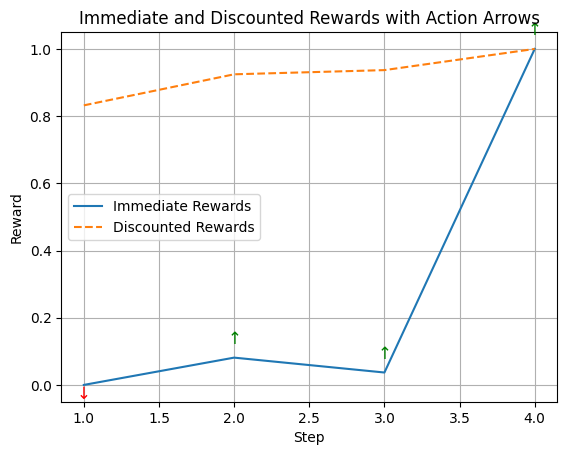

--- Current Environment State ---
Stock Ticker: KM
Date: 2000-7
Price: 1.1821307452919427e-05
Action Taken: ↑ (Buy)
Other Features: {'ebit_sale': 0.9999964833259583, 'ni_be': 0.43493711948394775, 'gp_at': 0.26697975397109985, 'oaccruals_at': 0.583949089050293, 'ni_ivol': 0.0016927606193348765, 'ni_me': 0.9048649668693542, 'capx_gr1': 7.318887219298631e-05, 'ebit_bev': 0.846259355545044, 'ni_ar1': 0.702535092830658, 'niq_at': 0.025262100622057915, 'niq_be_chg1': 0.9154041409492493, 'earnings_variability': 0.006897879298776388, 'ocf_at_chg1': 0.9149693846702576, 'at_be': 0.00015019967395346612, 'cash_at': 0.02280454710125923, 'chcsho_12m': 0.04115097597241402, 'netdebt_me': 0.029912713915109634, 'eqnetis_at': 0.5557976961135864, 'capx_gr3': 0.0003328897582832724, 'aliq_at': 0.00023271740064956248, 'debt_gr3': 2.9788359370286344e-06, 'aliq_mat': 0.016007954254746437, 'coa_gr1a': 0.9863554239273071, 'beta_60m': 0.27156054973602295, 'be_me': 0.02974874898791313, 'fcf_me': 0.2937909066677093

In [83]:
def main():
    json_file = 'feature_dict.json'  # Ensure this file exists with the correct format
    risk_params = {'stop_loss': 0.05, 'take_profit': 0.1}  # 5% stop loss, 10% take profit
    env = StockEnv(json_file_path=json_file, risk_params=risk_params, discount_factor=0.9)
    env.set_horizon(12)  # Set a horizon of 12 steps

    rewards = []
    steps = []
    actions = []
    positions = []
    observation = env.reset()
    done = False

    step_counter = 0
    while not done:
        step_counter += 1

        # For testing purposes, let's make the agent always buy at the start if not holding a position
        if env.position == 0:
            action = np.array([-1.0])  # Strong buy
        else:
            # When holding a position, decide to hold (do nothing)
            action = np.array([1.0])

        observation, reward, done, info = env.step(action)
        rewards.append(reward)
        actions.append(action[0])
        positions.append(env.position)
        steps.append(step_counter)
        ticker = info.get('stock_ticker', 'Unknown')

        print(f"Step {step_counter} - Reward: {reward:.4f} - Stock: {ticker} - Date: {info['date']} - Position: {env.position}")

    # Calculate discounted rewards
    discounted_rewards = env.calculate_discounted_rewards()

    # Print discounted rewards for each step
    for step, (reward, discounted_reward) in enumerate(zip(rewards, discounted_rewards)):
        print(f"Step {step + 1} - Immediate Reward: {reward:.4f}, Discounted Reward: {discounted_reward:.4f}")

    # Plot the rewards with action arrows and discounted rewards
    env.render_with_arrows(rewards, discounted_rewards, actions, steps)

    # Render the final state
    env.render()

if __name__ == "__main__":
    main()


In [87]:
import torch
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
GAMMA = 0.95
TAU = 1e-3

def train_agent(env, agent, n_episodes=1000):
    scores = []
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        agent.noise.reset()
        score = 0
        while True:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores.append(score)
        if i_episode % 10 == 0:
            print(f"Episode {i_episode}/{n_episodes}, Average Score: {np.mean(scores[-10:])}")
    return scores

def test_agent(env, agent, n_episodes=100):
    scores = []
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        agent.noise.reset()
        score = 0
        while True:
            action = agent.select_action(state, noise_scale=0.0)  # No noise during testing
            next_state, reward, done, _ = env.step(action)
            state = next_state
            score += reward
            if done:
                break
        scores.append(score)
        print(f"Test Episode {i_episode}/{n_episodes}, Score: {score}")
    print(f"Average Test Score over {n_episodes} episodes: {np.mean(scores)}")
    return scores



----- Run 1/30 -----
Training the agent...
Episode 100/1000, Average Reward: 0.0000
Episode 200/1000, Average Reward: -0.1882
Episode 300/1000, Average Reward: 0.0805
Episode 400/1000, Average Reward: 0.1373
Episode 500/1000, Average Reward: 0.2702
Episode 600/1000, Average Reward: 0.0025
Episode 700/1000, Average Reward: 0.1906
Episode 800/1000, Average Reward: 0.3417
Episode 900/1000, Average Reward: 0.3106
Episode 1000/1000, Average Reward: 0.1919
Testing the agent...
Test Episode 1/100, Reward: -1.0000
Test Episode 2/100, Reward: -0.9920
Test Episode 3/100, Reward: 1.0000
Test Episode 4/100, Reward: 1.0000
Test Episode 5/100, Reward: -1.0000
Test Episode 6/100, Reward: 1.0312
Test Episode 7/100, Reward: -0.7145
Test Episode 8/100, Reward: -0.0912
Test Episode 9/100, Reward: 0.5687
Test Episode 10/100, Reward: 0.9735
Test Episode 11/100, Reward: 1.0000
Test Episode 12/100, Reward: -1.0000
Test Episode 13/100, Reward: -1.0000
Test Episode 14/100, Reward: 1.3752
Test Episode 15/100, 

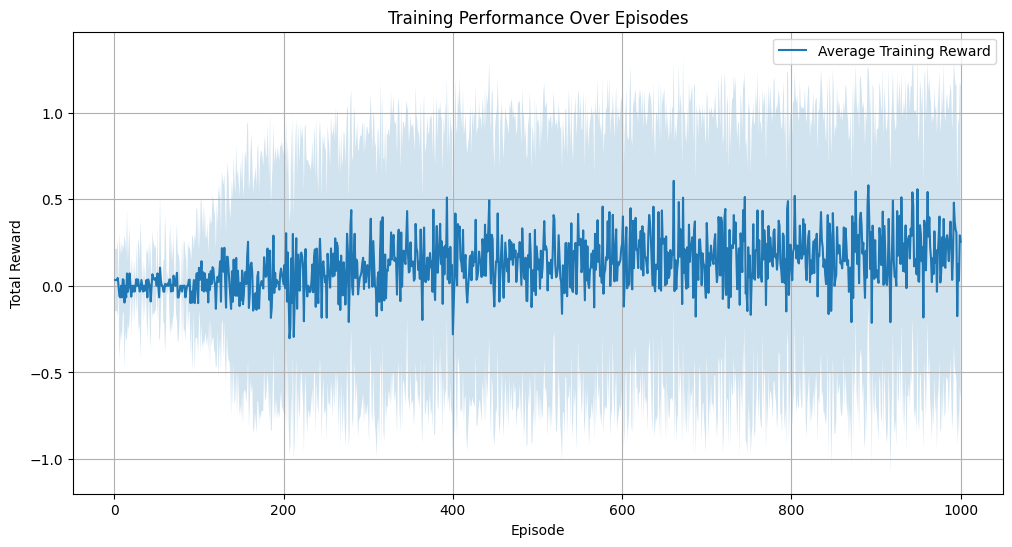

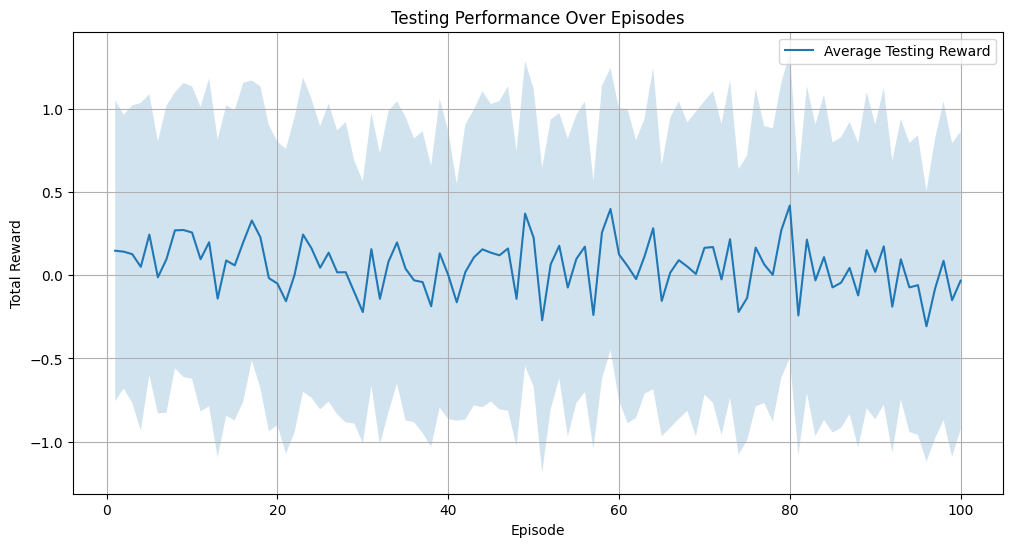

In [90]:

class ActorNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(ActorNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, action_size),
            nn.Tanh()  # Ensures output is between -1 and 1
        )

    def forward(self, state):
        return self.model(state)

class CriticNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(CriticNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(state_size + action_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        return self.model(x)

class ReplayBuffer:
    def __init__(self, buffer_size=1000000, batch_size=64):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        e = (state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = np.vstack([e[0] for e in experiences])
        actions = np.vstack([e[1] for e in experiences])
        rewards = np.array([e[2] for e in experiences], dtype=np.float32)
        next_states = np.vstack([e[3] for e in experiences])
        dones = np.array([e[4] for e in experiences], dtype=np.bool_)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

class DDPGAgent:
    def __init__(self, state_size, action_size, random_seed=0):
        self.state_size = state_size
        self.action_size = action_size

        # Actor Network (w/ Target Network)
        self.actor_local = ActorNetwork(state_size, action_size).to(device)
        self.actor_target = ActorNetwork(state_size, action_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=1e-4)

        # Critic Network (w/ Target Network)
        self.critic_local = CriticNetwork(state_size, action_size).to(device)
        self.critic_target = CriticNetwork(state_size, action_size).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=1e-3)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer()

        # Initialize target networks
        self.hard_update(self.actor_target, self.actor_local)
        self.hard_update(self.critic_target, self.critic_local)

    def hard_update(self, target, source):
        """Copy weights from source to target network"""
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)

    def select_action(self, state, noise_scale=1.0):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        action += noise_scale * self.noise.sample()
        return np.clip(action, -1, 1)

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every time step if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def learn(self, experiences, gamma):
        """Update policy and value parameters using batch of experience tuples."""
        states, actions, rewards, next_states, dones = experiences

        states = torch.FloatTensor(states).to(device)
        actions = torch.FloatTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones.astype(np.uint8)).unsqueeze(1).to(device)

        # Update Critic
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets.detach())
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Update Actor
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Update target networks
        self.soft_update(self.actor_local, self.actor_target, TAU)
        self.soft_update(self.critic_local, self.critic_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters."""
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process for adding noise to actions (exploration)."""
    def __init__(self, size, seed, mu=0.0, theta=0.15, sigma=0.2):
        self.size = size
        self.mu = mu * np.ones(self.size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state to mean mu."""
        self.state = np.copy(self.mu)

    def sample(self):
        """Generate a noise sample."""
        dx = self.theta * (self.mu - self.state) + self.sigma * np.array([random.gauss(0, 1) for _ in range(self.size)])
        self.state += dx
        return self.state

# Training and testing functions
def train_agent(env, agent, n_episodes=1000):
    episode_rewards = []
    for i_episode in range(1, n_episodes + 1):
        state = env.reset()
        agent.noise.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if done:
                break
        episode_rewards.append(total_reward)
        if i_episode % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            print(f"Episode {i_episode}/{n_episodes}, Average Reward: {avg_reward:.4f}")
    return episode_rewards

def test_agent(env, agent, n_episodes=100):
    episode_rewards = []
    for i_episode in range(1, n_episodes + 1):
        state = env.reset()
        agent.noise.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.select_action(state, noise_scale=0.0)  # No noise during testing
            next_state, reward, done, _ = env.step(action)
            state = next_state
            total_reward += reward
            if done:
                break
        episode_rewards.append(total_reward)
        print(f"Test Episode {i_episode}/{n_episodes}, Reward: {total_reward:.4f}")
    avg_test_reward = np.mean(episode_rewards)
    print(f"Average Test Reward over {n_episodes} episodes: {avg_test_reward:.4f}")
    return episode_rewards

# Main function with multiple runs and plotting
def main():
    json_file = 'feature_dict.json'  # Ensure this file exists with the correct format
    risk_params = {'stop_loss': 0.1, 'take_profit': 0.1}
    num_runs = 10
    n_train_episodes = 1000
    n_test_episodes = 100

    all_train_rewards = []
    all_test_rewards = []

    for run in range(1, num_runs + 1):
        print(f"\n----- Run {run}/{num_runs} -----")

        # Training environment
        train_env = StockEnv(json_file_path=json_file, risk_params=risk_params, mode='train', train_test_split_year=2010)
        train_env.set_horizon(6)

        state_size = train_env.observation_space.shape[0]
        action_size = train_env.action_space.shape[0]

        agent = DDPGAgent(state_size=state_size, action_size=action_size, random_seed=run)

        print("Training the agent...")
        train_rewards = train_agent(train_env, agent, n_episodes=n_train_episodes)
        all_train_rewards.append(train_rewards)

        # Save the trained models (optional)
        # torch.save(agent.actor_local.state_dict(), f'actor_model_run{run}.pth')
        # torch.save(agent.critic_local.state_dict(), f'critic_model_run{run}.pth')

        # Testing environment
        test_env = StockEnv(json_file_path=json_file, risk_params=risk_params, mode='test', train_test_split_year=2010)
        test_env.set_horizon(12)

        # Load the trained models (optional)
        # agent.actor_local.load_state_dict(torch.load(f'actor_model_run{run}.pth'))
        # agent.critic_local.load_state_dict(torch.load(f'critic_model_run{run}.pth'))

        print("Testing the agent...")
        test_rewards = test_agent(test_env, agent, n_episodes=n_test_episodes)
        all_test_rewards.append(test_rewards)

    # Convert rewards to NumPy arrays for easier manipulation
    all_train_rewards = np.array(all_train_rewards)  # Shape: (num_runs, n_train_episodes)
    all_test_rewards = np.array(all_test_rewards)    # Shape: (num_runs, n_test_episodes)

    # Calculate mean and standard deviation across runs
    mean_train_rewards = np.mean(all_train_rewards, axis=0)
    std_train_rewards = np.std(all_train_rewards, axis=0)

    mean_test_rewards = np.mean(all_test_rewards, axis=0)
    std_test_rewards = np.std(all_test_rewards, axis=0)

    # Plot training rewards
    plt.figure(figsize=(12, 6))
    episodes = np.arange(1, n_train_episodes + 1)
    plt.plot(episodes, mean_train_rewards, label='Average Training Reward')
    plt.fill_between(episodes, mean_train_rewards - std_train_rewards, mean_train_rewards + std_train_rewards, alpha=0.2)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Training Performance Over Episodes')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot testing rewards
    plt.figure(figsize=(12, 6))
    test_episodes = np.arange(1, n_test_episodes + 1)
    plt.plot(test_episodes, mean_test_rewards, label='Average Testing Reward')
    plt.fill_between(test_episodes, mean_test_rewards - std_test_rewards, mean_test_rewards + std_test_rewards, alpha=0.2)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Testing Performance Over Episodes')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Optional: Save the plots
    # plt.savefig('training_performance.png')
    # plt.savefig('testing_performance.png')

if __name__ == "__main__":
    main()